# Analysing data with Spark

A work by: Elliot Renel and Dorian Goepp.

Todo:
- [x] mise en forme des prints
- [x] ne plus afficher les exemples de données
- [x] relocalisation des imports
- [x] propre jusqu'à la question 6
- [x] utilisation de mapValues
- [x] générer un requirements.txt
- [ ] [générer un PDF](https://towardsdatascience.com/how-to-convert-jupyter-notebooks-into-pdf-5accaef3758)

## Dependencies for the project

Please note that all dependencies for this work are specified in a `pipfile`, which can be used to generate the appropriate python virtual environment. We also have a `requirements.txt` file.

Here are all the imports we need:

In [1]:
import matplotlib.pyplot as plt
from itertools import accumulate, islice
from operator import add
from math import ceil
import numpy as np
from tabulate import tabulate
from statistics import mean,median
from IPython.utils import io

## Downloading the data

Example command to download all the files for job events, running the downloads in parallel:

```bash
gsutil -m cp gs://clusterdata-2011-2/job_events/* ./job_events/
```

The parallelisation of the download is to take advantage of a high bandwidth internet connection. It would not help if the connection is slow.

As these are compressed with gzip, we need to un-compress them. There is an [easy way](https://stackoverflow.com/questions/16038087/extract-and-delete-all-gz-in-a-directory-linux) to do it for all files at once:

```bash
gunzip *.gz
```

> **Note:** As an afterthought, it might have been helpful to load the data directly from gzip files, saving some disk space at the cost of an increased computational load when a file is loaded.

## Parsing the schema file

The data we are working with is stored in CSV files of different "types", akin to tables in a relational database. Google provided a schema file (`schema.csv`) representing the fields of these CSV types.

To be able to make good use of the data, and to limit the risk of errors in selection of fields and handling of their format, we wrote a small python module to parse the schema file and help in loading and accessing the data in the CSV files.

In [3]:
# the Schema class of our utility module
from src.schema import Schema

Our module is used through an instance of the Schema class, as we will see later. The initialiser takes the path to the schema file provided by Google.

In [3]:
schema = Schema("data/schema.csv")

It is possible to print the object. This shows all the types of data in the data set. We commented the code block bellow as the output is quite verbose.

Note the `formatter` field. It is a function which will parse the input data and convert it to an appropriate Python type, based on the value in the `format` field of the schema.

With the line below, one can see all table types. We commented it to keep this document concise.

In [4]:
# print(schema)

## Starting Spark

We use Spark locally, using all available cores.

In [5]:
from pyspark import SparkContext

# start spark with as many worker threads as available on the machine
sc = SparkContext("local[*]")
sc.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/17 21:09:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Loading data and metadata

We here load all the tables we will use in this file. The `load_rdd` method we wrote in the Schema class does this for us. We give it the name of a table, and it fetches the related CSV files (if any) from the eponym folder in `data/` (for example, `data/machine_events`).

In [6]:
# Loading RDDs
machine_events = schema.load_rdd(sc, 'machine_events')
job_events = schema.load_rdd(sc,'job_events')
task_events = schema.load_rdd(sc,'task_events')
task_usage = schema.load_rdd(sc,"task_usage")

The following methods will be used later to access fields of the data by their name instead of their index.

In [7]:
# RDD field getters
machine_events_get = schema.field_getters('machine_events')
job_events_get = schema.field_getters('job_events')
task_events_get = schema.field_getters('task_events')
task_usage_get = schema.field_getters('task_usage')

## Distribution of CPU capacity (Q1)

We are looking for the distribution of machines according to their CPU capacity.

This computation relies on the machine events. Let us represent the schema for this data:


In [10]:
print(
    tabulate(
        schema.get_table_fields('machine_events', include_formatters=False),
        headers='keys'))

  field number  content      format       mandatory
--------------  -----------  -----------  -----------
             0  time         INTEGER      True
             1  machine ID   INTEGER      True
             2  event type   INTEGER      True
             3  platform ID  STRING_HASH  False
             4  CPUs         FLOAT        False
             5  Memory       FLOAT        False



For this analysis, we only account for the machine creation events, and keep the latest such event for any given machine. The intent is to avoid registering any machine's CPU more than once, should it have been offline for some time.

Keeping the latest creation event is arbitrary, but considers that it is highly unlikely for a machine's CPU to be changed over time.

The first three operations on `machine_events` concern the extraction of machine creation events and the selection of one single creation event for any given machine.

The following three operations sums the numbers of machines with any given CPU capacity. We use the same method we were introduced to for words counting during the classes.

Distribution of machine capacity based on their CPU power (normalised):

In [11]:
cpu = machine_events_get['CPUs']
event_type = machine_events_get['event type']
machine_id = machine_events_get['machine ID']
time = machine_events_get['time']

cpu_usage = machine_events \
    .filter(lambda event: event_type(event) == 0 and cpu(event) is not None) \
    .map(lambda event: (machine_id(event), event)) \
    .reduceByKey(lambda r1, r2: r1 if time(r1) > time(r2) else r2) \
    .map(lambda row: (cpu(row[1]), 1)) \
    .reduceByKey(add) \
    .sortBy(lambda x: x[0])

for usage, nb in cpu_usage.collect():
    print(f"{nb:<6} machines have CPU {usage}")

123    machines have CPU 0.25
11636  machines have CPU 0.5
796    machines have CPU 1.0


Here is a plot of the same data:

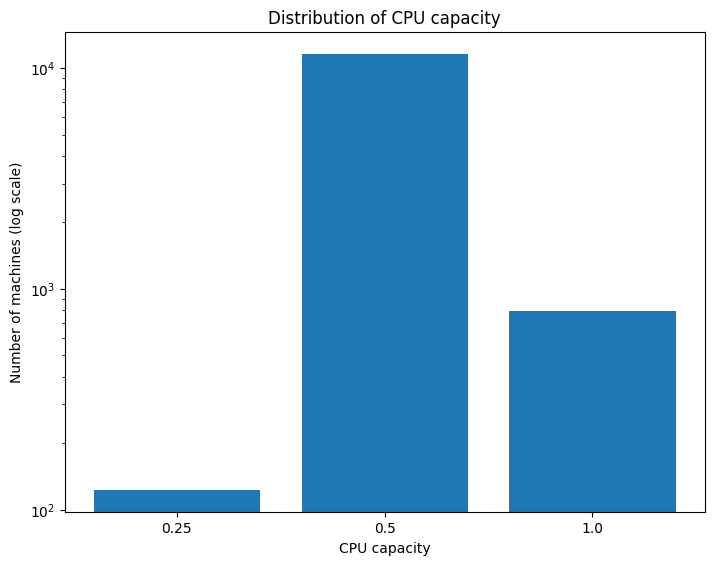

In [12]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
legend = cpu_usage.map(lambda x: str(
    x[0]) if x[0] is not None else 'None').collect()
count = cpu_usage.sortByKey().map(lambda x: x[1]).collect()
ax.bar(legend, count)

plt.xlabel("CPU capacity")
plt.ylabel("Number of machines (log scale)")
plt.title("Distribution of CPU capacity")

plt.yscale("log")
plt.show()

Please mind the y scale which is logarithmic, to better see the lesser occuring CPU capacities.

We observe that a vast majority of machines have half the maximum available CPU power. Less than ten times less machines have the full computational power and even less have a quarter of the maximal power.

## Lost Computational Power due to maintenance (Q2)

To begin with, we chose to interpret computational power as the product of CPU capacity with time. If the CPU capacity is a normalised version of CPU frequency, it means that such computational power represents a number of CPU cycles. Of course, two processors do not always perform the same number of instructions per cycle, but it is surely a good enough approximation for the task at hand.

As a reminder, here is the schema of the data we use:

In [9]:
print(
    tabulate(
        schema.get_table_fields('machine_events', include_formatters=False),
        headers='keys')
)

  field number  content      format       mandatory
--------------  -----------  -----------  -----------
             0  time         INTEGER      True
             1  machine ID   INTEGER      True
             2  event type   INTEGER      True
             3  platform ID  STRING_HASH  False
             4  CPUs         FLOAT        False
             5  Memory       FLOAT        False



This question requires that we study the story of each machine, namely when it was brought online and when it was put offline. So, as a first step, we create a new RDD where each element is a list of events regarding a machine.

To do so, we follow the map/reduce pattern. A last mapping operation removes the key-value mapping used for the map/reduce, as it is not needed later.

> **Note**: The latter operation might be a candidate for optimisation, should it become a bottleneck.

In [13]:
machines_history = machine_events \
    .map(lambda row: (machine_id(row), row)) \
    .aggregateByKey(None, lambda acc, e: acc+[e] if acc is not None else [e], add) \
    .map(lambda machine: machine[1])

Let us have a preview of the resulting data, taking three entries of the RDD:

In [14]:
for a_story in machines_history.take(3):
    print(tabulate(
        a_story,
        headers=schema.get_table_field_names('machine_events'),
        maxcolwidths=[None, None, None, 15, None, None]))
    print('\n')

  time    machine ID    event type  platform ID        CPUs    Memory
------  ------------  ------------  ---------------  ------  --------
     0             6             0  HofLGzk1Or/8Ild     0.5    0.2493
                                    j2+Lqv0UGGvY82N
                                    Loni8+J/Yy0RU=


         time    machine ID    event type  platform ID        CPUs    Memory
-------------  ------------  ------------  ---------------  ------  --------
            0            10             0  HofLGzk1Or/8Ild     0.5    0.2493
                                           j2+Lqv0UGGvY82N
                                           Loni8+J/Yy0RU=
1306164355566            10             1  HofLGzk1Or/8Ild     0.5    0.2493
                                           j2+Lqv0UGGvY82N
                                           Loni8+J/Yy0RU=
1307163081914            10             0  HofLGzk1Or/8Ild     0.5    0.2493
                                           j2+Lqv0UGGvY82N
       

And also see how many machines are covered in this sample data:

In [15]:
machines_history.count()

12583

During our exploration, we wondered whether the data was already sorted in the CSV source files by event time. The following counts the number of entries which are not sorted by time.

In [16]:
def to_event_times(history):
    """
    take the history of events for a machine (a list of events)
    and return the list of timestamps for these events, in the
    same order.
    """
    time_list = list()
    for event in history:
        time_list.append(machine_events_get['time'](event))
    return time_list


machines_history \
    .map(lambda events: to_event_times(events)) \
    .filter(lambda m: not sorted(m)) \
    .count()

0

The outcome is zero, showing that event entries are already sorted. The rest of our work on this question relies on this fact.

As the documentation for the data set states, the trace period starts at 600 seconds ($6 \times 10^{8} \mu s$). Therefore, to obtain the time of the end of the trace, we find the latest event time and subtracted $6 \times 10^{8}$ to it.

> **Note:** This assumes the absence of records dated after the end of the trace period. For these, the time value would be $2^{63} - 1$ (MAXINT). We did not encounter this value.

In [17]:
total_trace_time = time(machine_events.max(lambda row: time(row))) - 6*10**8

print(
    f'The total trace time is {total_trace_time} µs ≈ {ceil(total_trace_time/(10**6 * 3600))} hours ≈ {ceil(total_trace_time/(10**6 * 3600 * 24))} days')

The total trace time is 2505535493517 µs ≈ 696 hours ≈ 29 days


Once we have this number, computing the theoretical total computation power of a given machine is a matter of subtracting the starting time of the machine and multiplying by the CPU capacity. 

> **Note:** We assume that the CPU capacity of a machine never changes.

Also, there are some machines that have some cpu values at None, as shown below.

In [18]:
def has_none_cpu(events):
    cpu = machine_events_get['CPUs']
    for m in events:
        if cpu(m) is None:
            return True
    return False


print(f'There are {machines_history.filter(has_none_cpu).count()} machines with None values in their CPUs.')

There are 32 machines with None values in their CPUs.


The events for these machines could be perfectly valid. For instance, it could be an update event which does not affect the CPU. However, there are so few machines affected that we consider it harmless to exclude them from further analysis.

We also want to know how much time a machine was off. To compute this, we look for ADD and REMOVE machine events, considering the time between an ADD and a REMOVE as active time and time between a REMOVE and an ADD as off time.

> **Note:** We consider that a machine added after the start of the traces (time > 600s) has been added to the system at this point for the first time. Therefore, the time before is not counted as lost computational power.

We have had to handle the special case where a machine is removed but not brought back before the end of the trace. Our tests showed at least 17% of machines were in this situation with a sample of the data (not everything). This required us to change the way we processed the data below.

The function below does this processing for a given machine.

In [19]:
def lost_and_total_power(events):
    """
    Compute the time between installation of the machine (or start of the trace) and its final removal (or end of the trace). This also computes the sum of times the machine was offline between the two former time points.

    Then, these values are multiplied by the CPU capacity of the machine and returned as a tuple.
    """

    # Functions and Variables
    status = machine_events_get['event type']
    time = machine_events_get['time']
    start = time(events[0])
    cpu = machine_events_get['CPUs'](events[0])

    # Lost time
    lost_time = 0
    machine_off = True
    last_seen = None
    for event in events:
        if status(event) == 1 and not machine_off:  # machine removed
            last_seen = time(event)
            machine_off = True
        elif status(event) == 0 and machine_off:  # machine added
            machine_off = False
            if last_seen is not None:
                lost_time += time(event) - last_seen

    if machine_off and last_seen is not None:
        lost_time += total_trace_time + 6 * 10**8 - last_seen

    # Total time
    total_time = total_trace_time if (
        start < 6*10**8) else (total_trace_time - start + 6*10**8)

    # Resulting power
    return (lost_time*cpu, total_time*cpu)

The following keeps only machines which events all contain CPU information, and then applies the map/reduce scheme to compute the total and lost computational power.

In [22]:
power_lost_and_total = machines_history \
    .filter(lambda m: not has_none_cpu(m)) \
    .map(lost_and_total_power) \
    .reduce(lambda p1, p2: (p1[0]+p2[0], p1[1]+p2[1]))

print(f'During the trace time, around {(power_lost_and_total[0]/power_lost_and_total[1])*100:.4f}% of the computational power was lost.\
\nThe exact percentage obtained is {(power_lost_and_total[0]/power_lost_and_total[1])*100}% !')

During the trace time, around 0.6836% of the computational power was lost.
The exact percentage obtained is 0.6836289476194652% !


The lost computational power we obtained for the first sample of data is ≈0.68%, which seems to be quite an achievement.

## Distribution of jobs and tasks per scheduling class (Q3)

We will evaluate the distribution over **submitted** tasks and jobs. It also implies that we do not consider the distribution _over time_ but only within the _set_ of all submitted tasks and jobs.

We could also consider the evolution of the scheduling class through time, looking at the event types UPDATE_PENDING and UPDATE_RUNNING. This is a different perspective where time is a key component.

### Studying jobs

We start our analysis with jobs. They should be fewer than tasks, as there can be many tasks per job, but one job per task.

Before all, the schema for the tables we will use:

In [23]:
print(
    tabulate(
        schema.get_table_fields('job_events', include_formatters=False),
        headers='keys',
        maxcolwidths=40))

  field number  content           format       mandatory
--------------  ----------------  -----------  -----------
             0  time              INTEGER      True
             1  missing info      INTEGER      False
             2  job ID            INTEGER      True
             3  event type        INTEGER      True
             4  user              STRING_HASH  False
             5  scheduling class  INTEGER      False
             6  job name          STRING_HASH  False
             7  logical job name  STRING_HASH  False


Firstly, we gather the events based on the task or job they refer to. We expect such lists of events to be small enough to be handled in regular python lists.

In [24]:
job_events = schema.load_rdd(sc,'job_events')
job_events_get = schema.field_getters('job_events')

In [25]:
print(f"There are {job_events.count()} job events.")

There are 2012242 job events.


On Dorian's machine, the computation above took 46s (with other running programs).

We are interested in the job submission event, which is when they are assigned their (initial) scheduling class.

In [26]:
# event type 0 = SUBMIT
submit_events = job_events \
    .filter(lambda job_event: job_events_get['event type'](job_event) == 0) \
    .cache()

The documentation says that it is possible for a job to be submitted more than once, when it has been evicted, killed or when it failed but still is runnable (up to a maximal number of trials).

What if the the scheduling class had been changed when the job is submitted another time?

In [27]:
jobs_with_several_scheduling_classes = submit_events \
    .map(lambda job_event: (job_events_get['job ID'](job_event), 
                            {job_events_get['scheduling class'](job_event)})) \
    .reduceByKey(lambda event1, event2: event1 | event2) \
    .filter(lambda x: len(x[1]) > 1) \
    .count()

print(jobs_with_several_scheduling_classes)

0


None.

> **Note:** observe the curly braces used in `map` and `reduceByKey` above. We used python sets, which allow us to count all *distinct* scheduling classes a job was given.

Let us then proceed with gathering the scheduling classes. The first step will be to remove any duplicate, which the initial `map` and `distinct` calls do. We chose the `map` operation such that it allowed us to use mapValues below with a constant function.

In [28]:
job_scheduling_classes = submit_events \
    .map(lambda event: (job_events_get['scheduling class'](event),
                        job_events_get['job ID'](event))) \
    .distinct() \
    .countByKey()

for scheduling_class, count in sorted(job_scheduling_classes.items()):
    print(f"{count:<7} jobs are scheduled in class {scheduling_class}")

257275  jobs are scheduled in class 0
215109  jobs are scheduled in class 1
194513  jobs are scheduled in class 2
5177    jobs are scheduled in class 3


To better understand these values, let us plot them:

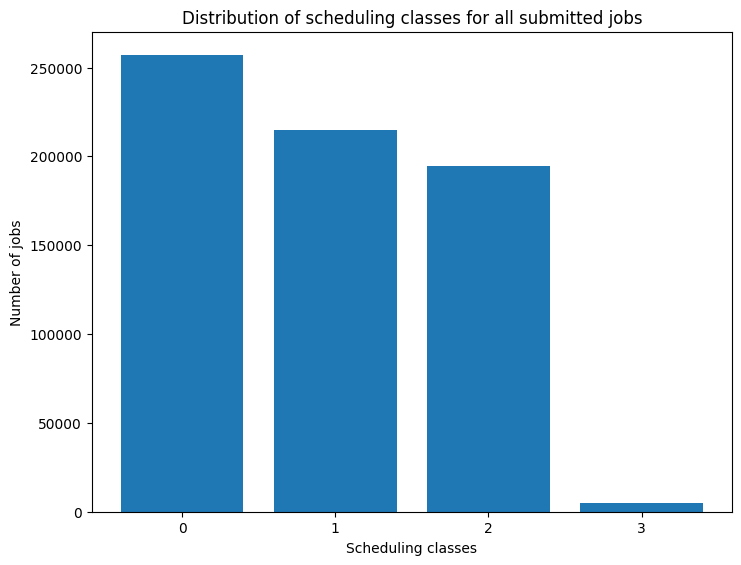

In [29]:
def bar_plot_question3(scheduling_classes, title, type):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    scheduling_class = list(scheduling_classes.keys())
    count = scheduling_classes.values()
    ax.bar(scheduling_class, count)
    plt.xlabel("Scheduling classes")
    plt.ylabel(f"Number of {type}")
    plt.xticks(scheduling_class)
    plt.title(title)
    plt.show()


bar_plot_question3(job_scheduling_classes,
                   "Distribution of scheduling classes for all submitted jobs", "jobs")

As a reminder, the scheduling class 3 is the most latency sensitive and 0 the least. The vast majority of jobs are of non-critical latency sensitivity, the more sensitive, the lesser the number.

It should be good, as insensitive jobs can be scheduled when the sensitive ones are not running, but do not suffer from being put aside when sensitive jobs have to take over. This should help maximising resource usage.

### Repeating the analysis for tasks

Let us now do the same analysis for all tasks, irrespective of which job they belong to.

Starting with the schema of the tasks events table

In [30]:
task_events_get = schema.field_getters('task_events')

print(
    tabulate(
        schema.get_table_fields('task_events', include_formatters=False),
        headers='keys',
        maxcolwidths=[None, 20, None, None, 40]))

  field number  content             format       mandatory
--------------  ------------------  -----------  -----------
             0  time                INTEGER      True
             1  missing info        INTEGER      False
             2  job ID              INTEGER      True
             3  task index          INTEGER      True
             4  machine ID          INTEGER      False
             5  event type          INTEGER      True
             6  user                STRING_HASH  False
             7  scheduling class    INTEGER      False
             8  priority            INTEGER      True
             9  CPU request         FLOAT        False
            10  memory request      FLOAT        False
            11  disk space request  FLOAT        False
            12  different machines  BOOLEAN      False
                restriction


Then, we load the data and filter for submission events.

In [31]:
task_events = schema.load_rdd(sc, 'task_events').persist()

task_submit_events = task_events \
    .filter(lambda task_event: task_events_get['event type'](task_event) == 0) \
    .cache()

A sample of this data, commented for conciseness, can displayed below.

In [32]:
# Basic version

# for task_event in task_submit_events.take(5):
#     print(task_event)

# This version is prettier, but too wide for some screens.

# print(
#     tabulate(
#         task_submit_events.take(5),
#         headers=schema.get_table_field_names('task_events'),
#         maxcolwidths=[None, None, None, None, None, None, 10]))

Following the same idea as for jobs, let us count how many tasks have been submitted more than once within different scheduling classes.

> **Note:** that here and after, we use a tuple as the key representing a task. Indeed, each task is represented by the job it belongs to and its task index. It does not have a unique identifier of its own.

In [33]:
tasks_with_several_scheduling_classes = task_submit_events \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)), 
                        {task_events_get['scheduling class'](event)})) \
    .reduceByKey(lambda event1, event2: event1 | event2) \
    .filter(lambda x: len(x[1]) > 1)

print(f'{tasks_with_several_scheduling_classes.count()} tasks have more than one scheduling class.')

0 tasks have more than one scheduling class.


From this, we conclude that, as with jobs, no task has ever seen its scheduling class changed after being resubmitted (due to eviction, failure, kill).

On to the distribution of scheduling classes:

In [34]:
task_scheduling_classes = task_submit_events \
    .map(lambda event: (
        task_events_get['scheduling class'](event),
        (task_events_get['job ID'](event), task_events_get['task index'](event)))) \
    .distinct() \
    .countByKey()

for scheduling_class, count in sorted(task_scheduling_classes.items()):
    print(f"{count:<7} tasks are scheduled in class {scheduling_class}")

2058961 tasks are scheduled in class 0
262933  tasks are scheduled in class 1
85911   tasks are scheduled in class 2
33074   tasks are scheduled in class 3


And the related plot, featuring both jobs and tasks:

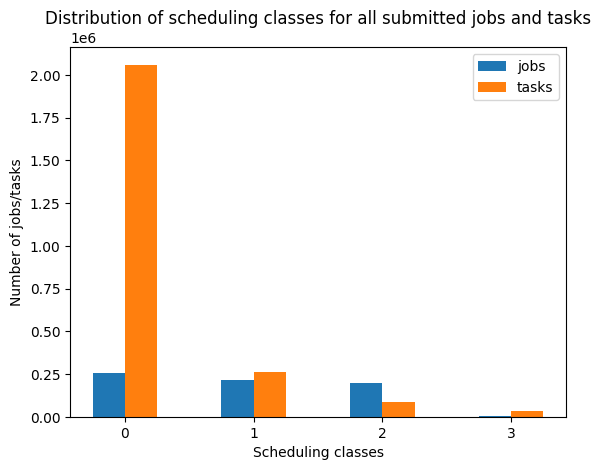

In [35]:
classes = range(0, 4)
w = 0.25

# Plotting jobs
scheduling_class = list(
    map(lambda x: (x - w/2), job_scheduling_classes.keys()))
count = job_scheduling_classes.values()
plt.bar(scheduling_class, count, width=w, align='center', label="jobs")

# Plotting tasks
scheduling_class = list(map(lambda x: x + w/2, task_scheduling_classes.keys()))
count = task_scheduling_classes.values()
plt.bar(scheduling_class, count, width=w, align='center', label="tasks")

plt.xlabel("Scheduling classes")
plt.ylabel("Number of jobs/tasks")
plt.xticks(classes, [str(a_class) for a_class in classes])
plt.title("Distribution of scheduling classes for all submitted jobs and tasks")
plt.legend()
plt.show()

## Relation between scheduling class and eviction of tasks (Q4)

We now focus on events of type 2, namely eviction events. These still rely on the task events, which schema we recall below.

In [36]:
print(
    tabulate(
        schema.get_table_fields(
            'task_events', include_formatters=False), headers='keys'))

  field number  content                         format       mandatory
--------------  ------------------------------  -----------  -----------
             0  time                            INTEGER      True
             1  missing info                    INTEGER      False
             2  job ID                          INTEGER      True
             3  task index                      INTEGER      True
             4  machine ID                      INTEGER      False
             5  event type                      INTEGER      True
             6  user                            STRING_HASH  False
             7  scheduling class                INTEGER      False
             8  priority                        INTEGER      True
             9  CPU request                     FLOAT        False
            10  memory request                  FLOAT        False
            11  disk space request              FLOAT        False
            12  different machines restriction  BOOLEAN  

Using the usual map/reduce pattern to count occurrences of a value, we gather the evictions per scheduling class.

In [37]:
scheduling_eviction_relations = task_events \
    .filter(lambda event: task_events_get['event type'](event) == 2) \
    .map(lambda event: (task_events_get['scheduling class'](event), 1)) \
    .reduceByKey(add) \
    .sortByKey() \
    .collect()

for relations in scheduling_eviction_relations:
    print(f"tasks of scheduling class {relations[0]} evicted: {relations[1]}")

tasks of scheduling class 0 evicted: 740876
tasks of scheduling class 1 evicted: 232409
tasks of scheduling class 2 evicted: 90950
tasks of scheduling class 3 evicted: 8590


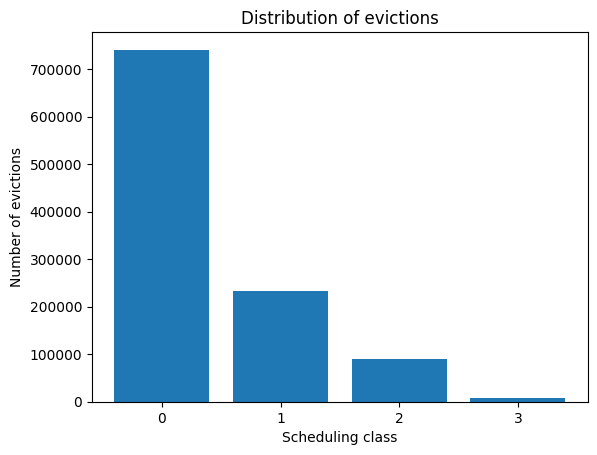

In [38]:
fig = plt.figure()

legend = list(map(lambda x: x[0], scheduling_eviction_relations))
count = list(map(lambda x: x[1], scheduling_eviction_relations))
plt.bar(legend, count)

plt.xlabel("Scheduling class")
plt.ylabel("Number of evictions")
plt.xticks(legend)
plt.title("Distribution of evictions")

plt.show()

Tasks with lower scheduling class were evicted much more than those with higher scheduling class. Note that we chose to keep all eviction events, even when a single task is evicted several times.

It matches the idea that latency-sensitive tasks, represented with higher scheduling classes, need to be interrupted (namely evicted) as little as possible, so that they can be completed soon.

## Same Job -> Same machine ? (Q5)

The job events table does not contain information about the machine running it. Indeed, it is the tasks which actually run on one or more machines. We will therefore use the task_events data, which schema is recalled here.

In [39]:
print(
    tabulate(
        schema.get_table_fields(
            'task_events', include_formatters=False), headers='keys'))

  field number  content                         format       mandatory
--------------  ------------------------------  -----------  -----------
             0  time                            INTEGER      True
             1  missing info                    INTEGER      False
             2  job ID                          INTEGER      True
             3  task index                      INTEGER      True
             4  machine ID                      INTEGER      False
             5  event type                      INTEGER      True
             6  user                            STRING_HASH  False
             7  scheduling class                INTEGER      False
             8  priority                        INTEGER      True
             9  CPU request                     FLOAT        False
            10  memory request                  FLOAT        False
            11  disk space request              FLOAT        False
            12  different machines restriction  BOOLEAN  

We will be using the fields `job ID` to identify the jobs, and `machine ID` for the tasks.

Here we use every task_event associated to any job ID and then we determine the number of machine used. From that, we compute how many jobs use any number of machines, with `countByValue()`.

In [40]:
nb_machines_per_job = task_events \
    .map(lambda event: (
        task_events_get["job ID"](event),
        {task_events_get["machine ID"](event)})) \
    .reduceByKey(lambda machine1, machine2: machine1 | machine2) \
    .map(lambda job: len(job[1])) \
    .countByValue()

print(f"The result contains {len(nb_machines_per_job)} entries.")

The result contains 1044 entries.


There are too many entries to display them all here. However, let us peek the first five of them.

We added a column representing the percentage of jobs using a given number of machines.

In [41]:
total_number_of_jobs = task_events \
    .map(lambda event: task_events_get['job ID'](event)) \
    .distinct() \
    .count()

sample_data = list()
for nb_machines, nb_jobs in islice(sorted(nb_machines_per_job.items()), 5):
    sample_data += [[nb_machines, nb_jobs, round(nb_jobs/total_number_of_jobs*100, 1)]]

print(tabulate(
    sample_data,
    headers=["# machines used", "# jobs", "percentage"]))

  # machines used    # jobs    percentage
-----------------  --------  ------------
                1      1635           3
                2     36621          67.8
                3      3102           5.7
                4       578           1.1
                5       341           0.6


A total of 69.5% of jobs used using one or two machine, with our sample of the data.

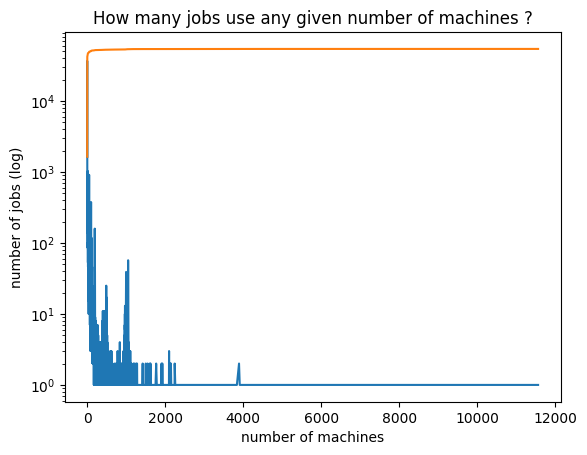

In [42]:
sorted_data = list(sorted(nb_machines_per_job.items()))
nb_machine, nb_jobs = list(zip(*sorted_data))

plt.plot(nb_machine, nb_jobs)

# Solution for cumulative function from https://www.geeksforgeeks.org/python-program-to-find-cumulative-sum-of-a-list/


def cumulative_sum(input_list):
    # Use the accumulate() function to perform a cumulative sum of the elements in the list
    cumulative_sum_iter = accumulate(input_list, add)
    # Convert the iterator to a list and return it
    return list(cumulative_sum_iter)


cumulative_count = cumulative_sum(nb_jobs)

plt.plot(nb_machine, cumulative_count)

plt.xlabel("number of machines")
plt.ylabel("number of jobs (log)")
plt.title("How many jobs use any given number of machines ?")

plt.yscale("log")
plt.show()


The orange line shows the cummulative sum of jobs. It lets us realise that the vast majority of jobs is concentrated in the very beginning, meaning with a very small number of machines. 

This shows again that it is most common to have all tasks from the a job run on 1 or 2 machines.

> **Note:** We chose to use a regular plot for this graphical representation, although, strictly speaking, a bar plot would be more accurate. However, we could not represent the number of bars required for this amount of data. This is why we chose the less exact representation. We believe it is still relevant enough to give us the information we are looking for.

## Comparison of resource request and resource usage of tasks (Q6)

This topic requires to do the analysis for three different resources: CPU cores, RAM and disk space. We will conduct our analysis on these three at the same time.

Also, our question calls for the usage of two sources of data : task events and resource usage. We will pre-process these separately and then join them.

### Resource requests

Tasks can specify resource requirements when SUBMITTED (0) and upon UPDATE_PENDING (7) and UPDATE_RUNNING (8) events.

As a reminder, here is the schema for task events:

In [43]:
print(
    tabulate(
        schema.get_table_fields('task_events', include_formatters=False),
        headers='keys'))

  field number  content                         format       mandatory
--------------  ------------------------------  -----------  -----------
             0  time                            INTEGER      True
             1  missing info                    INTEGER      False
             2  job ID                          INTEGER      True
             3  task index                      INTEGER      True
             4  machine ID                      INTEGER      False
             5  event type                      INTEGER      True
             6  user                            STRING_HASH  False
             7  scheduling class                INTEGER      False
             8  priority                        INTEGER      True
             9  CPU request                     FLOAT        False
            10  memory request                  FLOAT        False
            11  disk space request              FLOAT        False
            12  different machines restriction  BOOLEAN  

Do tasks update their resource requests during their lifecycle ?

To answer this question, we map task events to key-value pairs for each task, where the value contains the resource requests. Then with `reduceByKey`, we merge the resource requests to keep only distinct values (thanks to python's sets).

In [44]:
def task_event_to_resources(event):
    """
    Convert a task event to a key-value tuple.
    The key is the task id (combination of job ID and task index).
    The value is a dictionary of resource requests (keys are cpu, mem and disk). Each resource request is represented as a set of one or zero element. It is empty if the value for the given field is None.
    """
    task_id = (task_events_get['job ID'](event),
               task_events_get['task index'](event))

    CPU_request = task_events_get['CPU request'](event)
    mem_request = task_events_get['memory request'](event)
    disk_request = task_events_get['disk space request'](event)

    CPU_request = {CPU_request} if CPU_request is not None else set()
    mem_request = {mem_request} if mem_request is not None else set()
    disk_request = {disk_request} if disk_request is not None else set()

    return (task_id, {'cpu': CPU_request, 'mem': mem_request, 'disk': disk_request})


resource_requests = task_events \
    .map(task_event_to_resources) \
    .reduceByKey(lambda r1, r2: {
        'cpu': r1['cpu'] | r2['cpu'],
        'mem': r1['mem'] | r2['mem'],
        'disk': r1['disk'] | r2['disk']})

multiple_requests = resource_requests.filter(lambda event: len(
    event[1]['cpu']) > 1 or len(event[1]['mem']) > 1 or len(event[1]['disk']) > 1)

print(f"There has been {multiple_requests.count()} tasks changing at least one of their resource requests during their lifetime over a total of {resource_requests.count()} tasks, accounting for {multiple_requests.count() / resource_requests.count() * 100}%.")

Many tasks made more than one resource request in their lifetime. Here is a sample, to illustrate a few tasks requiring different amounts of resources. Each resource column is a set of all distinct values requested.

In [ ]:
requests = multiple_requests.take(5)
requests = [
    [request[0], request[1]['cpu'], request[1]['mem'], request[1]['disk']]
    for request in requests]

print(tabulate(
    requests,
    headers=['task', 'CPU', 'memory', 'disk']
))

task          CPU               memory              disk
------------  ----------------  ------------------  ----------------------
(3418314, 0)  {0.125, 0.0625}   {0.07446, 0.09473}  {0.0004244, 0.0004702}
(3418368, 0)  {0.03125, 0.125}  {0.08691, 0.09021}  {0.0008211, 0.0004549}
(3418368, 2)  {0.03125, 0.125}  {0.08691, 0.09021}  {0.0008211, 0.0004549}
(3418380, 0)  {0.1875, 0.125}   {0.09839, 0.08826}  {0.0008612, 0.0008135}
(3418400, 0)  {0.125}           {0.09082, 0.08923}  {0.0004702}


This implies that we will have to select which resource request to keep, or to compute an aggregate for any task.

Before that, let us also see at which events the CPU request is made. Is it only done at a given event type, like SUBMIT?

> **Note**: A task can be SUBMITed several times in its life.

In [ ]:
cpu_changing_events = task_events \
    .filter(lambda event: task_events_get['CPU request'](event) is not None) \
    .map(lambda event: task_events_get['event type'](event)) \
    .distinct() \
    .cache()

event_names = {
    0: 'SUBMIT',
    1: 'SCHEDULE',
    2: 'EVICT',
    3: 'FAIL',
    4: 'FINISH',
    5: 'KILL',
    6: 'LOST',
    7: 'UPDATE_PENDING',
    8: 'UPDATE_RUNNING'
}

events = ', '.join([event_names[event]
                   for event in cpu_changing_events.collect()])
print("Distinct CPU requests were made at events of types: ", events)

Distinct CPU requests were made at events of types:  SUBMIT, FINISH, EVICT, SCHEDULE, FAIL, KILL


As resource requests are made at different events, we have to process all types of events.

> **Note:** We could have pursued the investigation a little further to figure at which events the resource request is *updated*, not just present. However, the following does not require this information.

Since we are looking for the correlation between high resource request and high resource consumption, let us just take the highest resource request for each resource type.

In [ ]:
def max_resource_request(requests1, requests2):
    return tuple(
        max(r1, r2) for r1, r2 in zip(requests1, requests2)
    )


resource_requests = task_events \
    .filter(lambda event:
            task_events_get['CPU request'](event) is not None or
            task_events_get['memory request'](event) is not None or
            task_events_get['disk space request'](event) is not None) \
    .map(lambda event:
         (
             (task_events_get['job ID'](event),
              task_events_get['task index'](event)),
             (
                 task_events_get['CPU request'](event),
                 task_events_get['memory request'](event),
                 task_events_get['disk space request'](event)))) \
    .reduceByKey(max_resource_request) \
    .cache()

This aggregate will be used later in combination with the actual resource consumption of the tasks.

For now, we still have to gather the latter information.

### Resource usage table

The resource usage information is stored in its own table, `task_usage`.

> **Note:** The documentation for the data set specifies how the maximum measurement data is aggregated (for sub-containers), and gives a field in the table for this information. We believe, for the sake of this work, that we can spare ourselves the extra mileage of using this field, and just consider that the measurements are accurate enough. However, should we want a very accurate measurement, we would be more meticulous about this.

> **Note:** It is to be noted that resource measurement periods might overshoot after a task is killed. They did not prove problematic, so we kept these in our data.

First thing first, loading the related data set:

In [ ]:
task_usage_get = schema.field_getters('task_usage')
task_usage = schema.load_rdd(sc,'task_usage')

Let us see the format of this table:

In [ ]:
print(
    tabulate(
        schema.get_table_fields('task_usage', include_formatters=False),
        headers='keys'))

  field number  content                          format    mandatory
--------------  -------------------------------  --------  -----------
             0  start time                       INTEGER   True
             1  end time                         INTEGER   True
             2  job ID                           INTEGER   True
             3  task index                       INTEGER   True
             4  machine ID                       INTEGER   True
             5  CPU rate                         FLOAT     False
             6  canonical memory usage           FLOAT     False
             7  assigned memory usage            FLOAT     False
             8  unmapped page cache              FLOAT     False
             9  total page cache                 FLOAT     False
            10  maximum memory usage             FLOAT     False
            11  disk I/O time                    FLOAT     False
            12  local disk space usage           FLOAT     False
            13  maxi

There are many fields, but we will only use those on start/end time, job ID and task index (to identify a task) and maximum resource usage (fields 10, 12, 13). We chose to use the 'local disk space usage' field rather than focus on disk I/O time, as the only data we have for disk resource request is on disk space, not bandwidth.

To gather the resource usage per task, create a mapping between tasks and their resource usage. We then take the maximum of their usage on each resource, with `foldByKey`.

In [ ]:
resource_fields = [
    'maximum CPU rate',
    'maximum memory usage',
    'local disk space usage',
]


def entry_converter(entry):
    """ Extract selected resource fields from a task usage record"""
    return tuple(task_usage_get[field](entry) for field in resource_fields)


def combiner(elem1, elem2):
    """ Merge resource consumption records together, taking the highest value """
    return list(map(max, elem1, elem2))


resources_per_task = task_usage \
    .map(lambda entry: ((task_usage_get['job ID'](entry), task_usage_get['task index'](entry)),
                        entry_converter(entry))) \
    .foldByKey([0,]*(len(resource_fields)), combiner) \
    .cache()

In [ ]:
# To make sure that we formatted our data properly, let us show one sample

# for entry in resources_per_task.take(1):
#     print(f"The task {entry[0]} used at most :")
#     print(tabulate(zip(resource_fields, entry[1]), headers=['resource type', 'max usage']))

### Joining resource request with actual usage

In the previous two sections, we gathered resource requests and usage for each task. Having indexed the data by task identifiers, we can now use them to join and compare resource requests and usages for the tasks.

In [ ]:
joined = resource_requests \
    .join(resources_per_task) \
    .mapValues(lambda x: {
        'cpu': (x[0][0], x[1][0]),
        'mem': (x[0][1], x[1][1]),
        'disk': (x[0][2], x[1][2])}) \
    .cache()

In [ ]:
#A sample of this merged data

# for x in joined.take(5):
#     print(x)

We extract now the CPU, memory and disk request/usage data in their own variables to be plotted later.

In [ ]:
cpu_req_vs_usage = joined \
    .map(lambda x: x[1]['cpu']) \
    .collect()

mem_req_vs_usage = joined \
    .map(lambda x: x[1]['mem']) \
    .collect()

disk_req_vs_usage = joined \
    .map(lambda x: x[1]['disk']) \
    .collect()

And now, let us see how tasks use what they asked for.

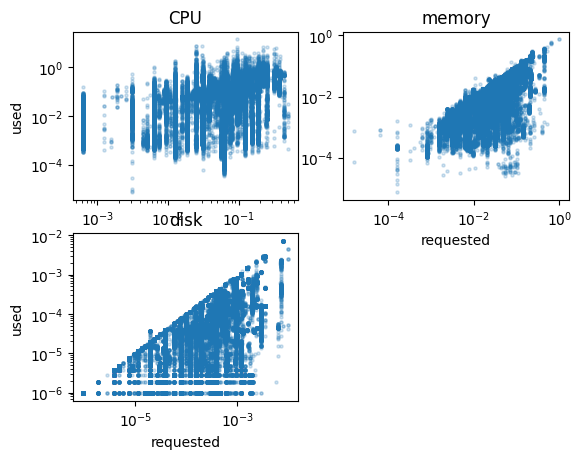

In [ ]:
# Size of the dots in the scatter plots
S=5

rspl = plt.subplot(2, 2, 1)
rspl.scatter(*zip(*cpu_req_vs_usage), s=S, alpha=0.2)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("used")
plt.title("CPU")
rspl = plt.subplot(2, 2, 2)
rspl.scatter(*zip(*mem_req_vs_usage), s=S, alpha=0.2)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("requested")
plt.title("memory")
rspl = plt.subplot(2, 2, 3)
rspl.scatter(*zip(*disk_req_vs_usage), s=S, alpha=0.2)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("requested")
plt.ylabel("used")
plt.title("disk")
plt.show()

These plots shows no stark correlation between CPU request and usage. There just are slightly higher CPU usage values at the right, and lower on the left of the plot.

However, we can observe a correlation for the memory and disk. At least the usages are capped by the request. It might be thanks to OS-based resource capping.

#### Discussion on resource usage metrics

Likewise, the choice of the metric for CPU usage could be argued. For the plots above, we used the CPU rate. We had also earlier tried about the sampled CPU usage, about which which the documentation says (our emphasis)

>  It is the average CPU usage during a one-second period that is picked uniformly at random from the 5-minute measurement period used for the other data in the row. For long-running tasks, this data can be used to build a *reasonably accurate stochastic model of CPU usage*.

This metric has by far been the most difficult to process, as it is difficult to interpret its meaning.

Regarding memory, we chose to keep the maximum memory used by the task. We consider it as a sensitive metric, as this is what we need to be ready for when allocating space for a task, notwithstanding the overbooking which Google says to have done in their cluster for better actual resource usage.

We have to be careful when interpreting disk space usage. The documentation states:

> Disk space recorded in this trace represents runtime local disk capacity usage. Disk usage  required for binaries and other read-only, pre-staged runtime files is ​not​ included. Additionally, most disk space used by distributed, persistent storage (e.g. GFS, Colossus) is not accounted for in this trace.

Meaning that what we plotted accounts only for a part of the real disk space used by tasks.

## Relation between resource usage peaks and task evictions (Q7)

We will investigate, for any given machine, whether there is a correlation  between resource consumption peaks and task evictions.

### Objective

To find a correlation, we will first construct a timeline, for each machine, of the maximum resource used, and the eviction events. Fortunately, the table Task Usage contains data on the maximum resource used withing a given time window. As such, we just need to correlate these resources with the eviction events. The documentation does not mention that tasks are migrated between machines, so we do not have to account for that.

Moreover, in the documentation we learn that the traces in our task usage data are done withing periods of 300 seconds starting at 600 seconds in the timeline. As such, to have a dataset easier to look at and perform operations on, we will form our timeline in epochs starting from 0. The first epoch 0 will therefore belongs to the time frame between 600s and 900s, epoch 1 will be between 900s and 1200s and so on.

We can verify that no task usage are recorded between epochs with the following test :

In [9]:
overlapping_epochs = task_usage \
    .map(lambda task: (task_usage_get['start time'](task), task_usage_get['end time'](task))) \
    .filter(lambda x: x[0]//300000000!=(x[1]-1)//300000000).count()
    # The -1 on the end time is to account for the events that ends at the end of an epoch (ex : 675s -> 900s is still withing epoch 0)
    

print(f"The number of events not inside a 300s period or epoch is {overlapping_epochs}.")


The number of events not inside a 300s period or epoch is 0.


Now that this is out of the way, we will also determine the maximum time of our dataset, so as to know how many epochs to account for.

In [10]:
usage_max_epoch = (task_usage.map(task_usage_get['start time']).max()-600000000)//300000000
event_max_epoch = (task_events.map(task_events_get['time']).max()-600000000)//300000000
max_epoch = min(usage_max_epoch,event_max_epoch) # We take the minimum of the two because it is going to be the relevant one in the intersection later

### Gathering task consumption peaks for all machines

The machine resource table contains machine IDs, so we can gather task consumption peaks for all machines on the one hand, and then task eviction events for all machines on the other hand. We can assume that no task can trigger two events at the same time, so we can ignore job ID and task index and only keep the machine ID.

We gather all maximum resource values for each machine, and their epochs :

In [11]:
def event_to_peak_resources(event):
    return {(task_usage_get['start time'](event)-600000000)//300000000 : 
                (task_usage_get['maximum CPU rate'](event), 
                task_usage_get['maximum memory usage'](event), 
                task_usage_get['maximum disk IO time'](event))
            }

def fuse_max_dictionary(d1,d2):
    for element in d2:
        if element in d1:
            a1, a2, a3 = d1[element]
            b1, b2, b3 = d2[element]
            d1[element] = (max(a1,b1),max(a2,b2),max(a3,b3))
        else :
            d1[element] = d2[element]
    return d1

default_dict = dict.fromkeys([a for a in range(0,max_epoch+1)],(.0,.0,.0))


machines_max_usage = task_usage \
    .filter(lambda event: task_usage_get['maximum memory usage'](event) is not None and \
        task_usage_get['maximum CPU rate'](event) is not None and \
        task_usage_get['maximum disk IO time'](event) is not None \
    ) \
    .map(lambda event: 
        (task_usage_get['machine ID'](event),
        event_to_peak_resources(event))) \
    .foldByKey(default_dict,lambda measurement1, measurement2: fuse_max_dictionary(measurement1,measurement2)) \
    .map(lambda machine: (machine[0],
            ([k for k,_ in machine[1].items()],
            [v[0] for _,v in machine[1].items()],
            [v[1] for _,v in machine[1].items()],
            [v[2] for _,v in machine[1].items()])
            )
        )\
    .cache()

### Gathering task eviction events for all machines

Now we look at the task events table, we only keep the EVICTION (2) events, and gather a list of epochs for each machine IDs.

In [12]:
def check(list):
    for e in list:
        if e!=0:
            return True
    return False

task_evict_events = task_events \
    .filter(lambda task_event: task_events_get['event type'](task_event) == 2) \
    .map(lambda event: (
            task_events_get['machine ID'](event),
            (task_events_get['time'](event)-600000000)//300000000
        )
    ) \
    .groupByKey() \
    .mapValues(list) \
    .mapValues(lambda v : list(np.histogram(v,np.arange(max_epoch+2))[0])) \
    .filter(lambda x: check(x[1]))

### Correlation Study

We perform a join operation to combine the two RDDs, considering that machine IDs only have one entry in each tables, we should still have one copy of each machine IDs in the table we obtain. As such, we obtain an RDD with the machine ID as a key, and a set of 5 arrays, representing :
- 0 : the epochs, from 0 to *max_epoch*
- 1 : maximum CPU rate on this machine in the corresponding epoch
- 2 : maximum memory usage on this machine in the corresponding epoch
- 3 : maximum disk IO time on this machine in the corresponding epoch
- 4 : number of eviction on this machine in the corresponding epoch

In [14]:
correlation = machines_max_usage.join(
    task_evict_events).mapValues(lambda x: (*x[0], x[1])) \
    .cache()


Now that we have our data for each machines, we need to correlate the eviction events and max resource usage for each periods. To do so we will first try to determine the correlation coefficient (also known as ***Pearson Correlation Coefficient***) for each machine and each resource usage. To do so we use the already existing *numpy* function *corrcoef*.

In [15]:
coefficients = correlation.map(lambda e: (
    [np.corrcoef(np.array(e[1][4]), np.array(e[1][1]))[1][0]],
    [np.corrcoef(np.array(e[1][4]), np.array(e[1][2]))[1][0]],
    [np.corrcoef(np.array(e[1][4]), np.array(e[1][3]))[1][0]]
)).reduce(lambda a, b: (a[0]+b[0], a[1]+b[1], a[2]+b[2]))


/home/akuma/.local/share/virtualenvs/SparkProject-DTXSDDnr/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/akuma/.local/share/virtualenvs/SparkProject-DTXSDDnr/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/akuma/.local/share/virtualenvs/SparkProject-DTXSDDnr/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/akuma/.local/share/virtualenvs/SparkProject-DTXSDDnr/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/akuma/.local/share/virtualenvs/SparkProject-DTXSDDnr/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/akuma/.local/s

The display of errors above is to be expected as the correlation coefficient needs to divide by the standard deviation of our sets, and some machines didn't have any eviction events, therefore end up with a standard deviation of 0.

In [16]:
max_coefficient = tuple([max(e) for e in coefficients])
min_coefficient = tuple([min(e) for e in coefficients])
average_coefficient = tuple([mean(e) for e in coefficients])
median_coefficient = tuple([median(e) for e in coefficients])

print(f"Maximum coefficients found : {max_coefficient}\nMinimum coefficients found : {min_coefficient}\nAverage of all coefficients : {average_coefficient}\nMedian coefficients : {median_coefficient}")

Maximum coefficients found : (0.9780996399005489, 1.0, 0.7786835576588109)
Minimum coefficients found : (-0.686292601076302, -0.999905756749502, -0.5688337699851276)
Average of all coefficients : (0.12192521190042006, nan, 0.07779399506536094)
Median coefficients : (0.09863104721262035, -0.04844101105048903, 0.0645486558407862)


As we can see, there are machines that seems to have correlations between the maximum resource used and the number of evictions, but the whole data (especially the mean and median) suggest that no such correlation exists.

If we don't try to look at the coefficients machine by machine, but try to find the correlation coefficient of the whole data set (while keeping X being the maximum resource used and Y the number of eviction), we obtain the following numbers :

In [18]:
cpu = correlation.map(lambda e: (e[1][1],e[1][4])).reduce(lambda a,b: (a[0]+b[0],a[1]+b[1]))
memory = correlation.map(lambda e: (e[1][2],e[1][4])).reduce(lambda a,b: (a[0]+b[0],a[1]+b[1]))
disk = correlation.map(lambda e: (e[1][3],e[1][4])).reduce(lambda a,b: (a[0]+b[0],a[1]+b[1]))

cpu_corr = np.corrcoef(np.array(cpu[0]),np.array(cpu[1]))[1][0]
memory_corr = np.corrcoef(np.array(memory[0]),np.array(memory[1]))[1][0]
disk_corr = np.corrcoef(np.array(disk[0]),np.array(disk[1]))[1][0]

print(f"The correlation coefficient between the number of evictions and the maximum cpu usage per epochs is {cpu_corr:0.4}")
print(f"The correlation coefficient between the number of evictions and the maximum memory usage per epochs is {memory_corr:0.4}")
print(f"The correlation coefficient between the number of evictions and the maximum disk usage per epochs is {disk_corr:0.4}")

The correlation coefficient between the number of evictions and the maximum cpu usage per epochs is 0.06333
The correlation coefficient between the number of evictions and the maximum memory usage per epochs is -0.006154
The correlation coefficient between the number of evictions and the maximum disk usage per epochs is 0.01382


As such, we can safely conclude that there are no correlation, negative of positive, between the picks of resources of a machine and its eviction events. 

Just for the sake of eye candy, here are the plots for each resource types maximum usage vs task evictions, where we can clearly see no correlations :

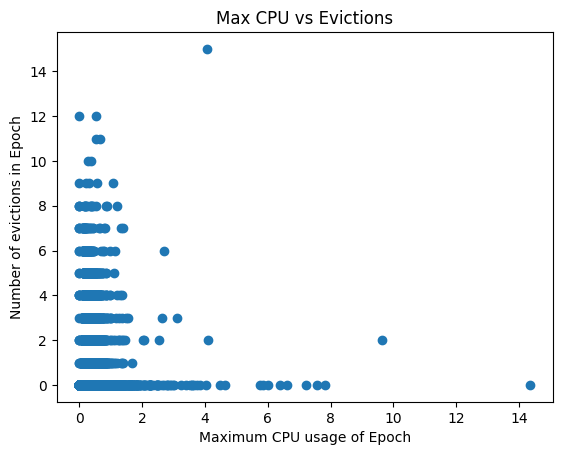

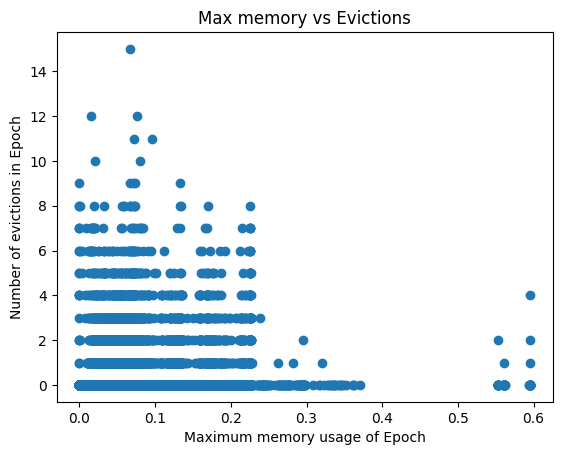

Text(0, 0.5, 'Number of evictions in Epoch')

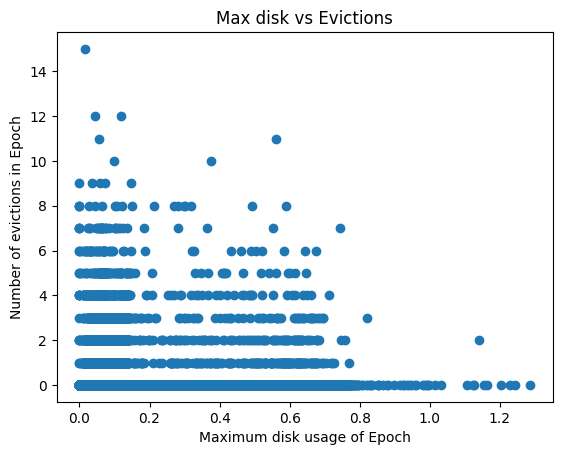

In [19]:
plt.scatter(*cpu)
plt.title("Max CPU vs Evictions")
plt.xlabel("Maximum CPU usage of Epoch")
plt.ylabel("Number of evictions in Epoch")
plt.show()
plt.scatter(*memory)
plt.title("Max memory vs Evictions")
plt.xlabel("Maximum memory usage of Epoch")
plt.ylabel("Number of evictions in Epoch")
plt.show()
plt.scatter(*disk)
plt.title("Max disk vs Evictions")
plt.xlabel("Maximum disk usage of Epoch")
plt.ylabel("Number of evictions in Epoch")

## Additional Questions (added by us)

Here are the final 2 questions that we came up with, each have their precisions to explain what it is we are looking for.

### 1 - Study of the relation between Scheduling Class and Dead Time

The Google documentation tells us that scheduling classes have different levels of latency sensitivity, with 3 supposedly having lower latency than 0. It also tells us that when a task dies (failed, evicted, etc.), the scheduler tries to submit it again as soon as possible. As such, we can verify the first statement by looking at the average time spent being dead for each classes. We should expect class 0 to have the most, and class 3 the least.

First, let's remind ourself of the distribution of scheduling classes : 

In [20]:
distribution = None
try :
    distribution = job_scheduling_classes
except NameError:
    distribution = job_events \
        .filter(lambda job_event: job_events_get['event type'](job_event) == 0) \
        .map(lambda event: (job_events_get['job ID'](event), job_events_get['scheduling class'](event))) \
        .distinct() \
        .map(lambda job_class: (job_class[1], 1)) \
        .reduceByKey(add) \
        .collect()

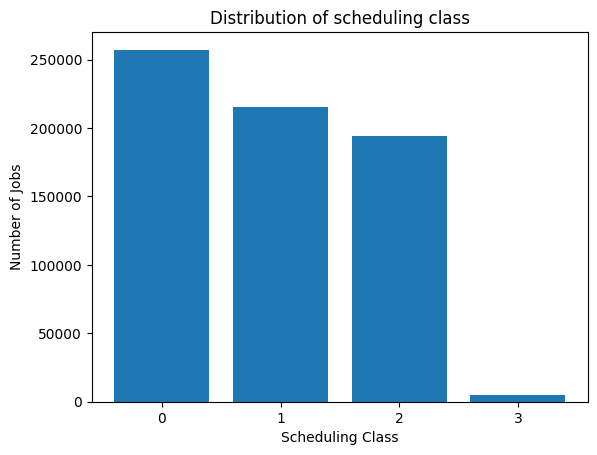

In [21]:
classes, hist = zip(*distribution)
classes = [str(e) for e in classes]
plt.bar(classes, hist)
plt.title("Distribution of scheduling class")
plt.xlabel("Scheduling Class")
plt.ylabel("Number of Jobs")
plt.show()

Now let us form the timeline of each jobs, then perform the necessary transformations to have the average death time for each class.

In [22]:
jobs_timeline = job_events \
    .filter(lambda event: job_events_get['event type'](event) not in {7,8}) \
    .map(lambda event: (
        (job_events_get['job ID'](event),job_events_get['scheduling class'](event)),
        (job_events_get['time'](event), job_events_get['event type'](event))
        )
    ) \
    .groupByKey() \
    .mapValues(list) \
    .cache()

In [28]:
def death_times(s_class, timeline):
    timeline.sort(key=lambda x: x[0])
    all_deaths = []
    for i in range(1,len(timeline)):
        if timeline[i-1][1] in {2,3,4,5,6} and timeline[i][1] == 0:
            all_deaths += [(s_class,timeline[i][0] - timeline[i-1][0])]
    if all_deaths == []:
        return [(s_class,0)]
    return all_deaths

average_death_duration_per_class = jobs_timeline \
    .flatMap(lambda job: death_times(job[0][1],job[1])) \
    .aggregateByKey(
        (0,0),
        lambda acc, data : (acc[0] + data, acc[1] + 1),
        lambda acc1, acc2 : (acc1[0] + acc2[0], acc1[1] + acc2[1])
    ).mapValues(lambda v: v[0]/v[1])

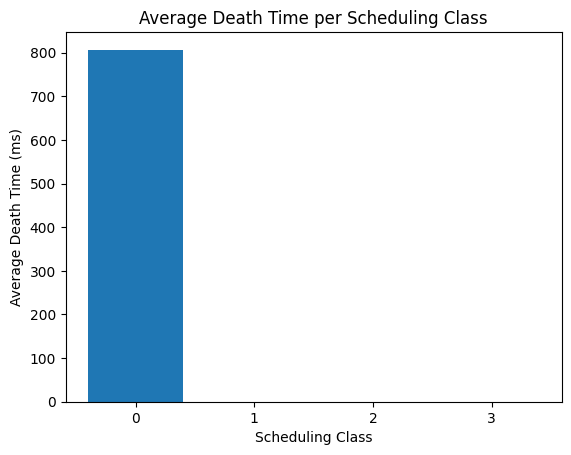

In [29]:
_ , data_death_time = zip(*average_death_duration_per_class.sortByKey().collect())
plt.bar([str(c) for c in range(4)],data_death_time)
plt.title("Average Death Time per Scheduling Class")
plt.xlabel("Scheduling Class")
plt.ylabel("Average Death Time (ms)")
plt.show()

We can see from the above graph that scheduling class 0 is the only class with any visible latency, which is slightly unexpected but does not contradict what was said in the google documentation.

### 2 - Task priority impact 

Is there a positive correlation between a task priority and the ratio of its life spent running. Logic would say that it does, as this is what we would expect the scheduler to do.

Preliminary questions:
- Can a task change priority level ?
- Do some tasks not have a FINISH (4) event at the end of their timeline ?

In [30]:
nb_tasks_several_priorities = task_events.map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)), {task_events_get['priority'](event)})) \
    .reduceByKey(lambda p1, p2: p1 | p2) \
    .filter(lambda task: len(task[1])>1) \
    .count()

print(f"There are {nb_tasks_several_priorities} tasks that have changed priorities.")

tasks_last_event_distribution = task_events \
    .map(lambda event: (
        (task_events_get['job ID'](event), task_events_get['task index'](event)),
        (task_events_get['time'](event), task_events_get['event type'](event))
        )
    ) \
    .reduceByKey(lambda e1,e2: e1 if e1[0] > e2[0] else e2) \
    .map(lambda event : (event[1][1],1)) \
    .reduceByKey(add) \
    .sortBy(lambda e: e[0]) \
    .collect()

print(f"The distribution of last events are as follows :\n{tabulate(tasks_last_event_distribution)}")


There are 142 tasks that have changed priorities.


The distribution of last events are as follows :
-  -------
0    21292
1   128291
2     1053
3     3339
4  1554453
5   731765
6      486
8      200
-  -------


Considering what we see, we need to filter events that have actually finished to have a relevant dataset for our question, as a task with high priority could have had a short life without running, getting a poor ratio as a result. We also need to filter by the timeline that starts with a submit, to prevent the cases where where a task changed priorities, and therefore doesn't have a full timeline.

Now that we know that, we just need to look at each task's timelines (similar to how we did it in question 2) and determine its running time, and whole life. 
We will need to determine the running time out of all it's life. The running time is the time between the events SCHEDULE (1) and either EVICT (2), FINISHED (4), FAIL (3), KILL (5), or LOST (6). The last 3 events can indeed happen even if the task has finished, as the Google documentation specifies, if those events happens, the scheduler will try to re-submit the task.

We will filter out the updates events, as they do not change the running status of our tasks.

In [31]:
tasks_timeline = task_events \
    .filter(lambda event: task_events_get['event type'](event) not in {7,8}) \
    .map(lambda event: (
        (task_events_get['job ID'](event), task_events_get['task index'](event), task_events_get['priority'](event)),
        (task_events_get['time'](event), task_events_get['event type'](event))
        )
    ) \
    .aggregateByKey(None,lambda acc, e: acc+[e] if acc is not None else [e],add) \
    .filter(lambda task: task[1][-1][1] == 4 and task[1][0][1] == 0) \
    .cache()

# print(f"We have a total of {tasks_timeline.count()} tasks timelines.")

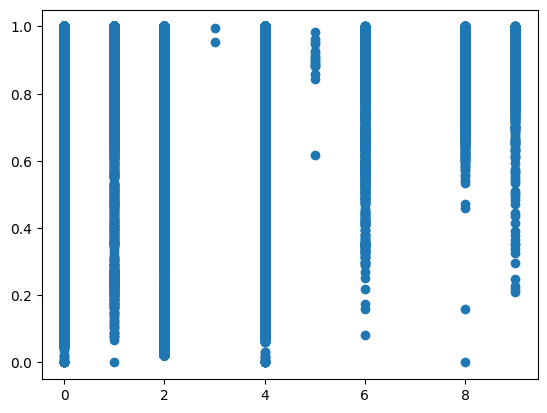

In [32]:
def running_ratio(timeline):
    timeline.sort(key=lambda x: x[0])
    total_time = timeline[-1][0] - timeline[0][0]
    if total_time==0 :
        total_time = 1
    running_time = 0
    for i in range(1,len(timeline)):
        if timeline[i-1][1] == 1 and timeline[i][1] in {2,3,4,5,6}:
            running_time += timeline[i][0] - timeline[i-1][0]
    return float(running_time) / float(total_time)

tasks_ratio = tasks_timeline.map(lambda task: (task[0][2],running_ratio(task[1])))

plt.scatter(*zip(*tasks_ratio.collect()))
plt.show()

Seeing all points does not help us, so let's see the average for each priority level.

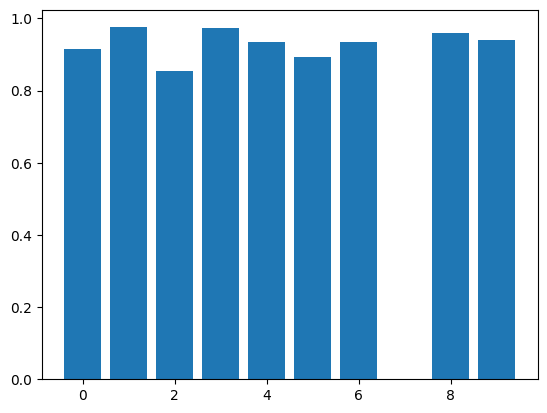

In [33]:
tasks_average_ratio = tasks_ratio \
    .map(lambda task: (task[0],(task[1],1))) \
    .reduceByKey(lambda t1,t2: (t1[0]+t2[0],t1[1]+t2[1])) \
    .map(lambda task: (task[0],task[1][0]/task[1][1]))

plt.bar(*zip(*tasks_average_ratio.collect()))
plt.show()

These results are very unexpected, the google documentation (page 8, Task events table section) clearly states that 0 is the lowest priority. But the document also states that there are 3 priority categories :
- free : lowest priority
- production : highest priorities
- monitoring : special category for jobs that monitor others

The graph we see might be a result of those 3 ranges, if we try to perform the above computations with more tables (currently 40, below with 100), we obtain the graph below :

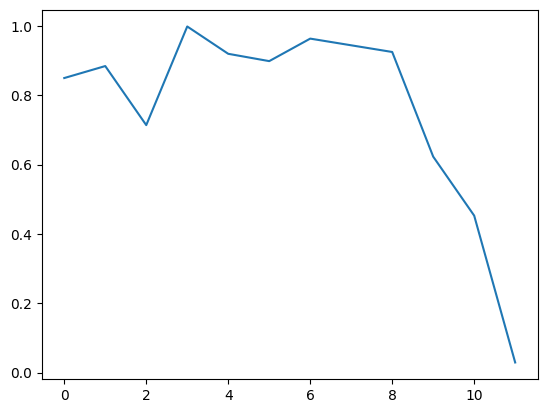

In [1]:
from IPython import display
display.Image("priority_runtime_100tables.png")

Seeing this new graph, we can have a better guess as to what the 3 categories are :
- 0 to 2 -> *free* (low overall runtime compared to next section)
- 3 to 8 -> *production* (consistently high overall runtime)
- 9 to 11 -> *monitoring* (big drop in runtime)

The number itself does not have much meaning then, except assigning you to one of the categories. As for the big drop in runtime for the last category, maybe monitoring has low ratios because it gets evicted often for long period monitoring, it does not need to run often, and therefore produces a lower ratio overall.

# Extension Work : DataFrame Version of previous work

As an extension for our work, we decided to use PySparkSQL DataFrame object instead of the RDD. We selected a few questions with different approach, and tried to redo them using DataFrames along with tools coming from PySparkSQL. 

Here are the results of our work, with both our successes and failures.

## Starting PySparkSQL and importing the schema

To use DataFrames, we need to use the SparkSession of PySparkSQL instead of the SparkContext. PySparkSQL allows the use the tabular methods provided by DataFrames. Spark offers a DataFrame API, through their Spark SQL.

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Cluster analysis") \
    .getOrCreate()

schema = Schema("./data/schema.csv")

## Importing tables into DataFrame

Importing .csv files into a DataFrame was a bit different from the RDD, but we found how to do it in the [documentation](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameReader.csv.html#pyspark.sql.DataFrameReader.csv) :

In [5]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType

# Mapping from field type as provided by the schema file, to their SparkSQL equivalent types
field_to_spark_type = {
    'time': LongType,
    'machine ID': LongType,
    'event type': IntegerType,
    'platform ID': StringType,
    'CPUs': FloatType,
    'Memory': FloatType
}

# Object representing the format of the data we will be loading, so SparkSQL can do the proper pre-processing
machine_events_schema = StructType([
    StructField(field['content'].replace(' ', '_'), field_to_spark_type[field['content']](), field['mandatory'])
    for field in schema.get_table_schema('machine_events')['fields']
])

machine_events_df = spark.read \
    .format('csv') \
    .option("header","false") \
    .schema(machine_events_schema) \
    .load("./data/machine_events/*.csv")

Let's see what the schema looks like, to see if it is what we expect it to be for machine events.

In [6]:
machine_events_df.printSchema()

root
 |-- time: long (nullable = true)
 |-- machine_ID: long (nullable = true)
 |-- event_type: integer (nullable = true)
 |-- platform_ID: string (nullable = true)
 |-- CPUs: float (nullable = true)
 |-- Memory: float (nullable = true)



## Distribution of CPU Capacity (Q1)

This question is simple enough to have a small expression that looks like what we did for RDDs :

In [7]:
creation_events = machine_events_df \
    .filter(machine_events_df.event_type == 0) \
    .filter(machine_events_df.CPUs.isNotNull())

cpu_counts = creation_events \
    .groupBy("machine_ID") \
    .agg({"time":"max","CPUs":"max"}) \
    .groupBy("max(CPUs)") \
    .count()

cpu_counts.show()

+---------+-----+
|max(CPUs)|count|
+---------+-----+
|     0.25|  123|
|      0.5|11636|
|      1.0|  796|
+---------+-----+



It is still different enough, as we have to use an aggregation function after the *groupBy*. Furthermore, the renaming of Columns is something we need to account for, except if we want to rename them after each operations with *withColumnRenamed*.

We can also use sql queries for the same purpose :

In [12]:
creation_events.createOrReplaceTempView("creation_events")

spark.sql("SELECT cpu as CPU_Value, COUNT(*) AS Number_Of_Machines "
            "FROM ("
                "SELECT machine_ID AS ID, max(CPUs) AS cpu "
                "FROM creation_events "
                "GROUP BY id "
            ") "
            "GROUP BY CPU_Value;").show()

+---------+------------------+
|CPU_Value|Number_Of_Machines|
+---------+------------------+
|     0.25|               123|
|      0.5|             11636|
|      1.0|               796|
+---------+------------------+



The above *select* gave small difficulties concerning the fact that we needed 2 groupBy back to back, that we were able to do via an embedded query from which we do the final groupBy. 

## Percentage of lost computational power (Q2)

We had the idea of doing this question because we thought it could be an interesting challenge, as it wasn't too hard to do it with RDD, but we didn't see how to do it with DataFrames at first. We nearly abandoned this question as an example of something we didn't manage to do with DataFrames but we managed to find a solution. This took a while.

Here are the approach we took to tackle this question with DataFrames.

#### Preliminary exploration

We first need to check a few things to know what to account for in our operations. First off, let us verify if the value of CPUs can be null :

In [13]:
machine_events_df.createOrReplaceTempView("machine_events")

bad_cpu_machines = spark.sql("SELECT DISTINCT machine_ID "
                             "FROM machine_events "
                             "WHERE CPUs IS NULL")
bad_cpu_machines.count()

32

Indeed it can, now let us see the maximum number of events on each machine :

In [14]:
spark.sql(
    "SELECT COUNT(*) as n_events FROM machine_events "
    "WHERE CPUs IS NOT NULL "
    "GROUP BY machine_ID "
    "ORDER BY n_events DESC "
    "LIMIT 1"
    ).show()

+--------+
|n_events|
+--------+
|     330|
+--------+



A machine has therefore at most 330 events, it is small enough that python can handle one machine. We'll therefore group the list of events, CPUs rates and timestamps for each machine IDs, then operate on them to determine the lost computational power of the cluster.

#### Machine timelines

We here group a list of timestamps, CPU rates, and event types, for later use to determine lost computational power.

In [15]:
grouped_machine_events = machine_events_df \
    .orderBy(machine_events_df['time']) \
    .groupBy(machine_events_df['machine_ID']) \
    .agg(
        F.collect_list('time').alias('time'),
        F.collect_list('event_type').alias('event_type'),
        F.max('CPUs').alias('cpu')) \
    .filter(F.col('cpu').isNotNull())

In [16]:
grouped_machine_events.show(5)

+----------+--------------------+----------+---+
|machine_ID|                time|event_type|cpu|
+----------+--------------------+----------+---+
|         5|[835150655707, 83...| [1, 0, 0]|0.5|
|         6|                 [0]|       [0]|0.5|
|         7|                 [0]|       [0]|0.5|
|        10|[1306164355566, 1...| [1, 0, 0]|0.5|
|        13|[2447693838527, 2...| [1, 0, 0]|0.5|
+----------+--------------------+----------+---+
only showing top 5 rows



#### Computational Power Lost

And now, we arrive at the problematic part. DataFrames are very powerful on many regards, but a weakness that we haven't found a solution to, is the fact that operations are done on columns, which is fine if there exists functions that we need in PySparkSQL, but gives difficulties if we need more complicated functions on serval columns. 

The idea we had was to add a new column with the method *withColumn*, and apply operations on the column time, event_type, and CPUs, but it wasn't a matter of just adding 3 numbers, or even do some simple vector operations. We need to retrieve the arrays inside each row, and apply operations on multiple element of the arrays at once (test 2 consecutive events, access 2 timestamps to get durations).

We found a solution by defining a *udf function*, which enables us to do an operation close to "mapping" :

In [17]:
from pyspark.sql.functions import udf, col

# Computing the lost power for each machine
def lost_power(time, event, cpu):
  acc = 0
  # The following test is here because some arrays had their first elements at the end, bu we could not figure out why
  if time[-1]>time[0]:
    for i in range(1,len(time)):
      if event[i-1] ==1 and event[i] == 0:
        acc += (time[i]-time[i-1]) * (cpu)
  else :
    for i in range(len(time)-1):
      if event[(i-1)%len(time)] ==1 and event[i] == 0:
        acc += (time[i]-time[(i-1)%len(time)]) * (cpu)
  return acc

# Finding the total power output of this machine
def total_power(time, event, cpu, max_time):
  if len(time)==1:
    return (max_time - time[0]) * cpu

  last_event_delete = False
  if time[-1]>time[0]:
    if event[-1] == 1:
      last_event_delete = True
  else :
    if event[-2] == 1:
      last_event_delete = True
  
  if last_event_delete:
    return (max(time) - min(time)) * cpu
  return (max_time - min(time)) * cpu

lost_power_udf = udf(lambda time, event, cpu: lost_power(time,event,cpu))
total_power_udf = udf(lambda time, event, cpu, max_time: total_power(time,event,cpu,max_time))

max_time_tmp = machine_events_df.select(F.max(machine_events_df.time)).collect()[0].asDict()['max(time)']

machine_lost_power = grouped_machine_events \
  .withColumn('max_time', F.lit(max_time_tmp)) \
  .withColumn('lost_power', lost_power_udf(col("time"),col("event_type"),col("cpu"))) \
  .withColumn('total_power', total_power_udf(col("time"),col("event_type"),col("cpu"),col("max_time")))

In [18]:
machine_lost_power.show(5)

+----------+--------------------+----------+---+-------------+-------------+------------------+
|machine_ID|                time|event_type|cpu|     max_time|   lost_power|       total_power|
+----------+--------------------+----------+---+-------------+-------------+------------------+
|         5|[835150655707, 83...| [1, 0, 0]|0.5|2506135493517|4.871238785E8|1.2530677467585E12|
|         6|                 [0]|       [0]|0.5|2506135493517|            0|1.2530677467585E12|
|         7|                 [0]|       [0]|0.5|2506135493517|            0|1.2530677467585E12|
|        10|[1306164355566, 1...| [1, 0, 0]|0.5|2506135493517| 4.99363174E8|1.2530677467585E12|
|        13|[2447693838527, 2...| [1, 0, 0]|0.5|2506135493517|4.986401075E8|1.2530677467585E12|
+----------+--------------------+----------+---+-------------+-------------+------------------+
only showing top 5 rows



As we can see, we needed to use the udf function to be able to do what we wanted. Now, we just need to do the final computation through a simple select and we are done.

In [19]:
percentage_of_lost_power = machine_lost_power.select(F.sum(col("lost_power")) / F.sum(col("total_power"))).collect()[0].asDict()['(sum(lost_power) / sum(total_power))']

print(f"The cluster lost around {percentage_of_lost_power*100:0.5f}% of power overall.")

The cluster lost around 0.48275% of power overall.


> **Note** : We have a different value than the ~0.68% from earlier, but it can be the result of the above code not taking into account the first 600s as active, whereas we removed it earlier. With almost all machine starting at time 0, this adds a lot of "available" time, lowering the above percentage.

## Do tasks from the same job run on the same machine (Q5)

For this question, we need to group task events by job IDs, then see how many *distinct* machine IDs we have, then do a histogram of it. With RDDs, we did it with maps and reduce using sets operations to account for distinct machine_ID. 

Using DataFrames, we are able to take advantage of groupBy then agg functions, along with column functions to make the process more straight forward.

Let's first load the task events :

In [20]:
# Mapping from field type as provided by the schema file, to their SparkSQL equivalent types
from pyspark.sql.types import BooleanType

field_to_spark_type = {
    'time': LongType,
    'missing info': LongType,
    'job ID': LongType,
    'task index': IntegerType,
    'machine ID': LongType,
    'event type': IntegerType,
    'user': StringType,
    'scheduling class': IntegerType,
    'priority': IntegerType,
    'CPU request': FloatType,
    'memory request': FloatType,
    'disk space request': FloatType,
    'different machines restriction': BooleanType
}

# Object representing the format of the data we will be loading, so SparkSQL can do the proper pre-processing
task_events_schema = StructType([
    StructField(field['content'].replace(' ', '_'), field_to_spark_type[field['content']](), field['mandatory'])
    for field in schema.get_table_schema('task_events')['fields']
])

task_events_df = spark.read \
    .format('csv') \
    .option("header","false") \
    .schema(task_events_schema) \
    .load("./data/task_events")

In [22]:
# task_events_df.show(5)

We note from the above display and the schema file that the attribute *machine_ID* can be *null*, as such, we need to filter it out before other operations.

In [24]:
different_machines_histogram = task_events_df.filter(task_events_df.machine_ID.isNotNull())\
    .groupBy("job_ID") \
    .agg(F.count_distinct(task_events_df.machine_ID)) \
    .groupBy("count(machine_ID)") \
    .agg({"job_ID":"count"}) \
    .orderBy("count(machine_ID)") \
    .withColumnRenamed("count(machine_ID)","nb_machine") \
    .withColumnRenamed("count(job_ID)","count") \
    .cache()

different_machines_histogram.show()

+----------+-----+
|nb_machine|count|
+----------+-----+
|         1|37656|
|         2| 3228|
|         3|  665|
|         4|  296|
|         5|  407|
|         6|  407|
|         7|  199|
|         8|  158|
|         9|  472|
|        10|  235|
|        11|  848|
|        12|  152|
|        13|   85|
|        14|  324|
|        15| 1031|
|        16|  231|
|        17|   79|
|        18|  107|
|        19|   45|
|        20|  110|
+----------+-----+
only showing top 20 rows



Let us gather the data into a chart to see these results in a better light.

In [25]:
iterator = different_machines_histogram.toLocalIterator()
X = []
Y = []

for row in iterator:
    d = row.asDict()
    X += [d["nb_machine"]]
    Y += [d["count"]]

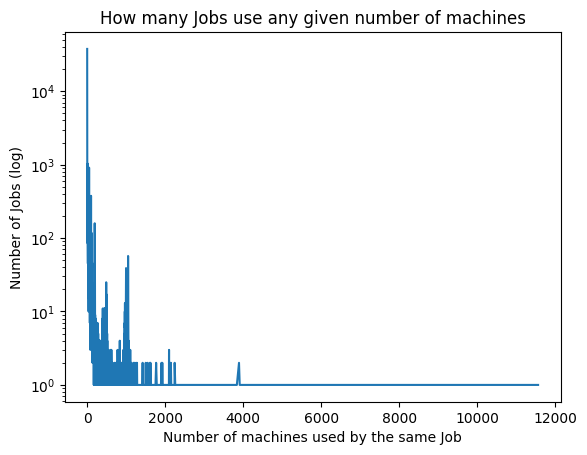

In [30]:
plt.plot(X,Y)
plt.yscale("log")
plt.title("How many Jobs use any given number of machines")
plt.xlabel("Number of machines used by the same Job")
plt.ylabel("Number of Jobs (log)")
plt.show()